BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


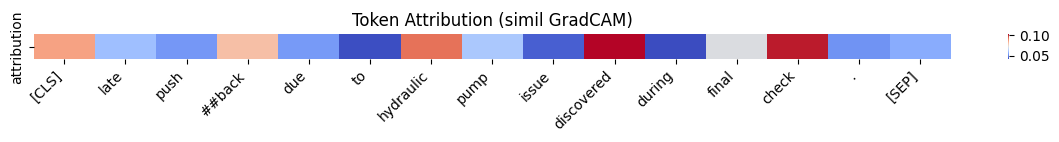

In [2]:
# Aircraft Delay Log - Interpretabilità con Token Attribution (simil Grad-CAM)

from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carica modello e tokenizer
model_name = "microsoft/deberta-v3-small"
model = AutoModelForSequenceClassification.from_pretrained("../model/delay_classifier", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model.eval()

def visualize_token_contributions(text, label_map):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)

    # Estrai attention dall'ultimo layer
    attn = outputs.attentions[-1]  # [batch, heads, seq_len, seq_len]
    attn = attn.mean(dim=1)[0]     # media su teste, shape: [seq_len, seq_len]
    token_weights = attn[0]        # attenzione rispetto al token [CLS]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_weights = token_weights.detach().numpy()

    # Visualizza
    plt.figure(figsize=(12, 1.5))
    sns.heatmap([token_weights], cmap="coolwarm", xticklabels=tokens, yticklabels=["attribution"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Token Attribution (simil GradCAM)")
    plt.tight_layout()
    plt.show()

# Esempio
label_map = {
    0: "TECHNICAL_FAILURE",
    1: "CREW_DELAY",
    2: "WEATHER",
    3: "ATC_RESTRICTION",
    4: "LOGISTICS_ISSUE",
    5: "SECURITY"
}

example_text = "Late pushback due to hydraulic pump issue discovered during final check."
visualize_token_contributions(example_text, label_map)
